#### Agnieszka Marciszewska
## Analysis of Unstracted Data
### list 3

Using Google YouTube API analyze two channels' data (influencers from the same area).
You should investigate:
1. Users stats
2. Videos Stats
3. Two selected video stats

Channels requirements:
* Please select channels which are not new (has data) and youtubers publish videos not
occasionally
* For 2nd point, please analyze data for all users videos (e.g. Views in time)
* For 3rd point, please select one video for each user and analyze it (e.g. In case of comment sentiments)

Please provide the following information in jupyter notebook:
* Links to channels
* describe the channels content (area)
* tell why you selected these channels and why you compare selected videos (try to find the topic for your analysis)
* indicate the differences and similarities between channels (in the analysis

In [1]:
import numpy as np
import datetime
import pandas as pd
from googleapiclient.discovery import build
import urllib.parse as p
import re
import os
import requests
import pickle
import scrapetube
from nltk.sentiment import SentimentIntensityAnalyzer 
import matplotlib.pyplot as plt

In [2]:
#####################################################################################################

We choose two channel about traveling. Both channels content area are travel videos in different countries. Channels have around 100 videos.


In [3]:
channel1 = "https://youtube.com/@LexieLimitless"
channel2 = "https://youtube.com/@RyanShirley"

In [4]:
#####################################################################################################

In [5]:
def get_video_id_by_url(url):
    parsed_url = p.urlparse(url)
    video_id = p.parse_qs(parsed_url.query).get("v")
    if video_id:
        return video_id[0]
    else:
        raise Exception(f"Wasn't able to parse video URL: {url}")

In [6]:
def print_video_infos(video_response):
    items = video_response.get("items")[0]
    snippet         = items["snippet"]
    statistics      = items["statistics"]
    content_details = items["contentDetails"]
    
    publish_time  = snippet["publishedAt"]
    title         = snippet["title"]
    
    like_count    = statistics["likeCount"]
    view_count    = statistics["viewCount"]
    comment_count = statistics["commentCount"]
    duration = content_details["duration"]

    if duration[-1] == 'M':
        duration=duration+'00S'

    parsed_duration = re.search(f"PT(\d+H)?(\d+M)?(\d+S)", duration).groups()
    duration_str = ""
    if len(parsed_duration[2])==2:
        y = list(parsed_duration)
        y[2] = '0' +parsed_duration[2][0] + parsed_duration[2][1]
        parsed_duration = tuple(y)

    for d in parsed_duration:
        if d:
            duration_str += f"{d[:-1]}:"
    duration_str = duration_str.strip(":")
    
    return    like_count, view_count, comment_count, publish_time[:publish_time.rfind('T')],duration_str,title

In [7]:
def get_video_details(youtube, **kwargs):
    return youtube.videos().list(part="snippet,contentDetails,statistics",**kwargs).execute()

In [8]:
api_key = ********************************
youtube = build('youtube', 'v3', developerKey=api_key)

In [9]:
def get_info(url):
    #przeszukujemy konkretny kanał
    api_key = ********************************
    youtube = build('youtube', 'v3', developerKey=api_key)
    videos = scrapetube.get_channel(channel_id = None, channel_url=url)
    videos_adress_id = []
    for video in videos:
        videos_adress_id.append(video['videoId']) #lista z adresami filmów
        
    number_of_videos = len(videos_adress_id) 

    number_of_all_comments = np.empty([number_of_videos])
    number_of_all_likes = np.empty([number_of_videos])
    number_of_all_views = np.empty([number_of_videos])
    publish_dates = []
    duration_of_videos = []
    titles = []
    
    url_single = 'https://www.youtube.com/watch?v='

    for v_url in range(number_of_videos):
        url_single_video = url_single + videos_adress_id[v_url] #adress id konkretnego filmu
        video_id = get_video_id_by_url(url_single_video)
        response = get_video_details(youtube, id=video_id)
        like_count, view_count, comment_count, video_date, duration_video, title = print_video_infos(response)
        number_of_all_comments[v_url] = int(comment_count)
        number_of_all_likes[v_url] = int(like_count)
        number_of_all_views[v_url] = int(view_count)
        publish_dates.append(video_date)
        duration_of_videos.append(duration_video)
        titles.append(title)
    return  number_of_all_likes,number_of_all_views,number_of_all_comments, publish_dates,duration_of_videos,titles

In [10]:
def stat_channel(channel_url):
    
    likes ,views ,comments, dates, duration,_  = get_info(channel_url)
    total = len(likes)
    duration_time = count_time(duration,total)
    data_stat = {'Channel name':[channel_url[channel_url.rfind('@')+1:]],
                 '#video':[total],
                '#views':[int(sum(views))],
                '#likes':[int(sum(likes))],
                 '#comments':[int(sum(comments))],
                 'avg. likes':[int(sum(likes)/total)],
                 'avg. views':[int(sum(views)/total)],
                 'avg. comments':[int(sum(comments)/total)],
                 '1st video':[dates[-1]],
                 'last video':[dates[0]],
                 'average duration of videos':[duration_time[1]]
                }

    df = pd.DataFrame(data_stat)
    return df

In [11]:
def count_time(t,l):
    mysum = datetime.timedelta()
    for i in t:
        c = i.count(':')
        if c == 1:
            (m, s) = i.split(':')
            h = 0
        if c ==2:
            (h, m, s) = i.split(':')
        if c ==0:
            m = i
            s = 0
            h = 0
        d = datetime.timedelta(hours = int(h), minutes=int(m), seconds=int(s))
        mysum += d
    return(str(mysum),str(mysum/l))

In [12]:
def video_info(channel_url):
    
    likes ,views ,comments, dates, duration,title  = get_info(channel_url)
    df = pd.DataFrame(list(zip(title, views, likes, comments, duration, dates)),
               columns =['Title', 'Views','Likes','Comments','Duration','Publish date'])
    return df

In [13]:
#####################################################################################################
# Channel statistics

In [14]:
stat_channel(channel1)

,Channel name,#video,#views,#likes,#comments,avg. likes,avg. views,avg. comments,1st video,last video,average duration of videos
0,LexieLimitless,101,19460550,743713,55976,7363,192678,554,2019-11-20,2023-01-07,0:14:17.712871


In [15]:
stat_channel(channel2)

,Channel name,#video,#views,#likes,#comments,avg. likes,avg. views,avg. comments,1st video,last video,average duration of videos
0,RyanShirley,154,67108276,1232037,85269,8000,435768,553,2009-10-14,2023-01-01,0:10:41.032468


In [16]:
#####################################################################################################
# Videos statistics

In [17]:
video_info1 = video_info(channel1)
video_info1

,Title,Views,Likes,Comments,Duration,Publish date
0,I Explored the Ancient Temples of CAMBODIA,20380.0,975.0,194.0,6:58,2023-01-07
1,23 INSANELY CHEAP Destinations for Budget Trav...,107509.0,2825.0,331.0,22:27,2022-12-26
2,Traveling Across Thailand for 100 Hours with $100,18757.0,931.0,92.0,23:11,2022-12-10
3,Top 10 Most Beautiful Ancient Places in the World,13885.0,957.0,100.0,12:36,2022-12-04
4,BEST vs. WORST Reviewed Hotel in BANGKOK,34603.0,1250.0,106.0,16:35,2022-11-20
...,...,...,...,...,...,...
96,"ABANDONED Billionaire's Mansion | $10,000,000 ...",92159.0,4580.0,354.0,10:21,2020-01-07
97,The 5 Most Surprising Countries *After Traveli...,479647.0,26076.0,2293.0,6:33,2019-12-18
98,Climbing Africa's Most Dangerous Volcano,194636.0,11915.0,1031.0,14:05,2019-12-09
99,How I Became the Youngest to Travel to Every C...,1285360.0,71632.0,4362.0,6:54,2019-12-03


In [18]:
video_info2 = video_info(channel2)
video_info2

,Title,Views,Likes,Comments,Duration,Publish date
0,Top 10 Places To Visit in 2023 (Year of Travel),392617.0,7070.0,533.0,10:07,2023-01-01
1,Top 25 Places To Visit in Switzerland - Travel...,66433.0,1684.0,238.0,18:21,2022-12-25
2,Top 100 Places To Visit in Europe - Ultimate T...,4533668.0,36802.0,1431.0,1:8:09,2022-11-27
3,Top 25 Places To Visit On The British Isles - ...,24425.0,809.0,195.0,15:08,2022-11-06
4,Top 25 Places To visit in Portugal - Travel Guide,207185.0,4322.0,355.0,15:07,2022-10-16
...,...,...,...,...,...,...
149,Bubble Rings Slow Motion,6669.0,51.0,3.0,48,2013-09-04
150,World's Greatest Rope Swing,3434.0,43.0,13.0,32,2012-09-28
151,Cliff Jumping and Rope Swings!,10089.0,94.0,14.0,3:50,2012-09-18
152,Parkour Europe,4184.0,63.0,11.0,59,2011-08-15


In [19]:
top5_videos = video_info1.sort_values(by='Views', ascending=False).head(5)
top5_videos

,Title,Views,Likes,Comments,Duration,Publish date
82,I Joined a BILLION Muslims in FASTING For a Day,1453041.0,84681.0,10229.0,14:40,2020-05-10
99,How I Became the Youngest to Travel to Every C...,1285360.0,71632.0,4362.0,6:54,2019-12-03
83,The Best Surprise of My Life in ITALY!,1079016.0,33522.0,1675.0,9:23,2020-05-03
90,The Most Beautiful Free Diving in the World,818380.0,27501.0,706.0,3:00,2020-02-23
15,Eating The World's Best Pizza in ITALY,812668.0,13338.0,972.0,12:16,2022-06-04


In [20]:
top5_videos = video_info2.sort_values(by='Views', ascending=False).head(5)
top5_videos

,Title,Views,Likes,Comments,Duration,Publish date
53,Top 100 Places To Visit In Europe,12369756.0,132808.0,6857.0,52:38,2020-10-09
2,Top 100 Places To Visit in Europe - Ultimate T...,4533668.0,36802.0,1431.0,1:8:09,2022-11-27
19,Top 100 Places To Visit In Italy - Ultimate Tr...,2994061.0,43395.0,2918.0,46:58,2022-01-01
87,Top 10 Places To Visit In Europe,2898235.0,117408.0,4950.0,11:19,2019-10-09
62,Top 10 Places To Visit In The UK,2801971.0,49543.0,4321.0,9:21,2020-08-07


In [21]:
def cumplotveiws(url):
    _,number_of_all_views,_, publish_dates,_,_ = get_info(url)
    x = np.linspace(1,len(number_of_all_views),len(number_of_all_views))
    x2 = x[0::5]
    publish_dates = publish_dates[::-1]#reverse
    publish_dates2 = publish_dates[0::5]#take every 5th element
    number_of_all_views = number_of_all_views[::-1]
    cum_v = np.cumsum(number_of_all_views)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(x, cum_v)
    ax.set_xticks(x2)
    ax.set_xticklabels(publish_dates2,rotation=45)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumultative sum of view')
    name = url[url.rfind('@')+1:]
    ax.set_title('Cumultative sum of view for channel: {}'.format(name))


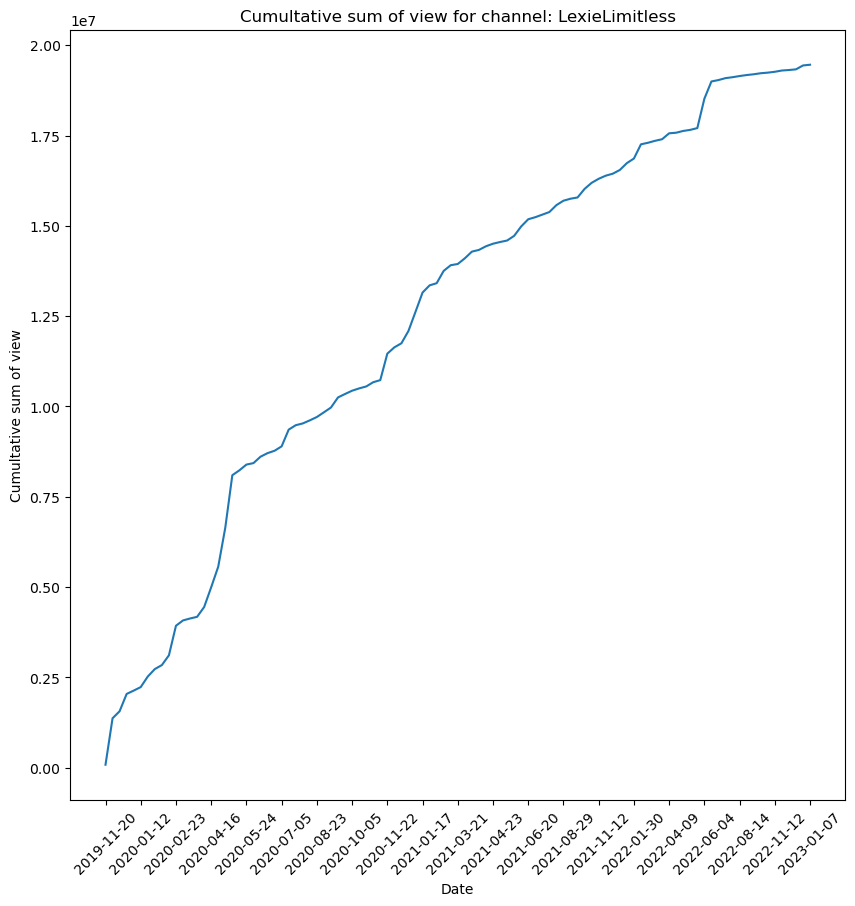

In [22]:
cumplotveiws(channel1)

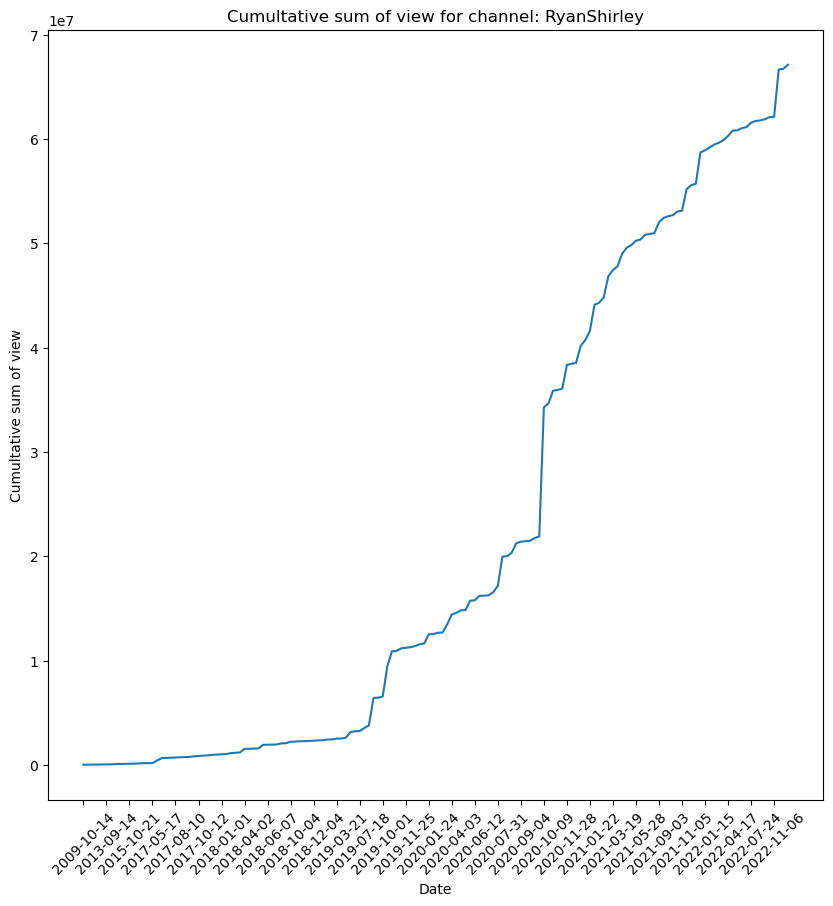

In [23]:
cumplotveiws(channel2)

In [24]:
#############################################################################################################################
# comments
#############################################################################################################################

In [25]:
def get_comments(youtube, video_id, next_view_token):
    global all_comments
    if len(next_view_token.strip()) == 0:
        all_comments = []
    if next_view_token == '':
        comment_list = youtube.commentThreads().list(part = 'snippet', videoId = video_id, order = 'relevance').execute()
    else:
        comment_list = youtube.commentThreads().list(part = 'snippet', videoId = video_id, order='relevance', pageToken=next_view_token).execute()
    
    for comment in comment_list['items']:
        all_comments.append([comment['snippet']['topLevelComment']['snippet']['textDisplay']])
        reply_count = comment['snippet']['totalReplyCount']
        all_replies = []
        if reply_count > 0:
            replies_list = youtube.comments().list(part='snippet', parentId=comment['id']).execute()
            for reply in replies_list['items']:
                all_replies.append(reply['snippet']['textDisplay'])

            while "nextPageToken" in replies_list:
                token_reply = replies_list['nextPageToken']
                replies_list = youtube.comments().list(part = 'snippet', parentId = comment['id'], pageToken = token_reply).execute()
                for reply in replies_list['items']:
                    all_replies.append(reply['snippet']['textDisplay'])
        all_comments[-1].append(all_replies)
    if "nextPageToken" in comment_list:
        return get_comments(youtube, video_id, comment_list['nextPageToken'])
    else:
        return []

In [26]:
def comment_analysis(video_url):
    video_id = get_video_id_by_url(video_url)
    api_key = ********************************
    youtube = build('youtube', 'v3', developerKey=api_key)
    get_comments(youtube, video_id, '')
    SIA = SentimentIntensityAnalyzer() 
    count_negative = 0
    count_positive = 0
    count_neutral = 0
   
    for comment, replies in all_comments:
        comment_score = SIA.polarity_scores(comment)["compound"]
        if comment_score > 0:
            count_positive += 1
        if comment_score == 0:
            count_neutral += 1
        if comment_score < 0:
            count_negative += 1
        if len(replies) > 0:
            for reply in replies:
                reply_score = SIA.polarity_scores(reply)["compound"]
                if reply_score > 0:
                    count_positive += 1
                if reply_score == 0:
                    count_neutral += 1
                if reply_score < 0:
                    count_negative += 1

    return count_positive, count_negative, count_neutral

In [27]:
def comment_statistics(video_url):
    
    api_key = ********************************
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_id = get_video_id_by_url(video_url)
    response = get_video_details(youtube, id=video_id)
    like_count, view_count, comment_count, video_date, duration_video, title = print_video_infos(response)
    
    count_positive, count_negative, count_neutral = comment_analysis(video_url)

    comment_overall = count_positive + count_negative + count_neutral
    percent_pos = count_positive / comment_overall
    percent_neg = count_negative / comment_overall
    percent_neu = count_neutral / comment_overall
    
    
    print('Video title: ',title)
    print('Published: ',video_date)
    print('Number of likes: ',like_count)
    print('Number of views: ',view_count)
    print('Duration of video: ',duration_video)
    
    print('This video has ',comment_overall, ' comments.')
    print('There are ', count_positive, ' positive comments, which is', "{:.0%}".format(percent_pos),'of all comments')
    print('There are ', count_negative, ' negative comments, which is', "{:.0%}".format(percent_neg),'of all comments')
    print('There are ', count_neutral, ' neutral comments, which is', "{:.0%}".format(percent_neu),'of all comments')

We took a video on a similar topic. Both films present subjective top places to visit in europe.

In [28]:
#channel1 @LexieLimitless
comment_statistics("https://www.youtube.com/watch?v=PaukPDAUOq0")

Video title:  Top 12 AMAZING Places to Travel in Europe
Published:  2021-08-14
Number of likes:  6381
Number of views:  191555
Duration of video:  25:39
This video has  372  comments.
There are  228  positive comments, which is 61% of all comments
There are  38  negative comments, which is 10% of all comments
There are  106  neutral comments, which is 28% of all comments


In [29]:
#channel2 @RyanShirley
comment_statistics("https://www.youtube.com/watch?v=GRdWHN5VrgI")

Video title:  Top 10 Places To Visit In Europe
Published:  2019-10-09
Number of likes:  117408
Number of views:  2898237
Duration of video:  11:19
This video has  4315  comments.
There are  2425  positive comments, which is 56% of all comments
There are  447  negative comments, which is 10% of all comments
There are  1443  neutral comments, which is 33% of all comments
